In [1]:
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading a document and preprocess using tika

In [2]:
import tika
from tika import parser
from Levenshtein import distance as levenshtein_distance
import re


def read_file(fileName):
    PDF_Parse = parser.from_file(fileName)
    text = PDF_Parse['content']
    return text



def split_pages( input_text=""):
    
    no_newlines = input_text.strip("\n")  # remove leading and trailing "\n"
    
    re_page = re.compile(r"\n{3,}") 
    split_text = re_page.split(no_newlines)  # regex splitting
    
    
    # p.strip() == True if paragraph has other characters than whitespace
    pages = [p.strip("\n") for p in split_text if p.strip()]

    return pages


def remove_repeating_paragraphs(pages, verbose = False):
    pages = [page.split("\n\n") for page in pages]
    for page_index in range(len(pages)):
        pages[page_index] = [paragraph.strip().replace("\n"," ").replace("  "," ") for paragraph in pages[page_index] if paragraph.strip() and len(paragraph.split()) > 3]
    page =0 
    while page <len(pages):
        paragraph = 0
        while paragraph < len(pages[page]):
            repeating = [(page, paragraph)]
            for i in range(page+1, len(pages)):
                for j in range(len(pages[i])):
                    dist = levenshtein_distance(pages[i][j], pages[page][paragraph]) 
                    if dist < len(pages[i][j])/5 or dist < 5:
                        repeating.append((i,j))
        
                        
            if len(repeating) > len(pages)/12:
                if verbose:
                    print("removing :", pages[page][paragraph] ," with ", len(repeating), "occurences")
                for pair in repeating[::-1]:
                    pages[pair[0]].pop(pair[1])
            else:
                paragraph+=1
        page+=1
                
    return pages

def clean_pages(pages):
    for i in range(len(pages)):
        for j in range(len(pages[i])):
            p = re.sub(r'http\S+', '', pages[i][j])
            p = re.sub(r'[^a-zA-Z0-9.]', ' ', p) 
            p = re.sub(r' {3,}',' ', p)
            p = p.strip()
            p = p.lower()
            pages[i][j] = p
    return pages



def concat_paragraphs(pages):
    paragraphs = []
    for page in pages:
        paragraphs+= page
    return paragraphs

def correct_paragraphs(paragraphs):
    corrected_paragraphs = []
    i= 0
    while i < len(paragraphs):
        if paragraphs[i] == "":
            paragraphs.pop(i)
        else:
            i+=1
    #Sometimes a paragraphs continue in the other block in the case of a lack of space
    #So if it's not the end of the sentence we concatenate both blocks
    i = 0
    while i < len(paragraphs):
        corrected_paragraphs.append(paragraphs[i])
        while paragraphs[i][-1] not in [";", ".", "?","!",":"] and i < len(paragraphs) - 1 :
            i+=1
            
            corrected_paragraphs[-1] = corrected_paragraphs[-1] + " " + paragraphs[i]
        i+=1
    return corrected_paragraphs
    
    
def remove_stop_words(pages, threshold = 0.6,verbose = False):
    unique_words = list(set(" ".join([" ".join(p) for p in pages ]).replace("."," ").replace("  "," ").split(" ")))
    word_count = {}

    for i in range(len(unique_words)):
        word_count[unique_words[i]] = 0
        for page in pages:
            for paragraph in page:
                if unique_words[i] in paragraph.split():
                    word_count[unique_words[i]] +=1

    threshold *= len(pages)

    for word in unique_words:
        if word_count[word] > threshold:
            if verbose:
                print("deleting : ", word ,word_count[word])
            for page_index in range(len(pages)):
                for para_index in range(len(pages[page_index])):
                    pages[page_index][para_index] = " ".join([a for a in pages[page_index][para_index].split() if a != word])

    return pages



def extract_text(fileName, verbose = False):
    
    text = read_file(fileName)
    if verbose:
        print("File Loaded")
    pages = split_pages(text)
    
    if verbose:
        print("Removing Repeating paragraphs")
    pages = remove_repeating_paragraphs(pages, verbose)
    if verbose:
        print("Removing stop words and common words")
    pages = clean_pages(pages)
    pages = remove_stop_words(pages,threshold = 0.6, verbose = verbose)
    paragraphs = concat_paragraphs(pages)
    if verbose:
        print("Correcting paragraphs")
    #paragraphs = correct_paragraphs(paragraphs)
    if verbose:
        print("Extracted")
    return(paragraphs)
docs = extract_text("/Users/SB6282engie.com/Documents/Policy documents/Bristol/One City Climate Strategy.pdf" )

In [341]:
docs

['resilient',
 'foreword one environmental sustainability board',
 'facing emergency. act now reduce direct indirect net zero. prepare adapt deal projected impacts change.',
 'one plan committed becoming resilient 2030.',
 'achieve over next decade radically rethink how live work invest city.',
 'regionally nationally internationally.',
 'provides opportunity take collaborative inclusive citywide approach make fair transition.',
 'environmental sustainability board proud lead transition city. representing range organisations come together set out shared vision strategy.',
 'given strong history delivering excited work hand hand continue lead way. move faster than national average learning other cities journey.',
 'sets vision where based sound science. would like thank colleagues advisory committee their review challenge evidence bristol.',
 'recognise achieving vision not easy. there entrenched market wider forces existing fossil fuel dependent consumption based systems. show strong l

# Coreference resolution using spacy's neuralcoref

In [3]:
#Resolve coreferences
import spacy 
import neuralcoref
def resolve_coref(docs):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length *=2
    neuralcoref.add_to_pipe(nlp)
    full_doc = " <cut_here> ".join(docs)
    doc_coref_resolved= nlp(full_doc)._.coref_resolved
    doc_coref_resolved = doc_coref_resolved.split(" <cut_here> ")
    return doc_coref_resolved

# Bert Topic

Housing Strategy 2016
number of paragraphs :  280


2022-03-10 13:22:13,958 - BERTopic - Transformed documents to Embeddings
2022-03-10 13:22:17,271 - BERTopic - Reduced dimensionality with UMAP
2022-03-10 13:22:17,338 - BERTopic - Clustered UMAP embeddings with HDBSCAN


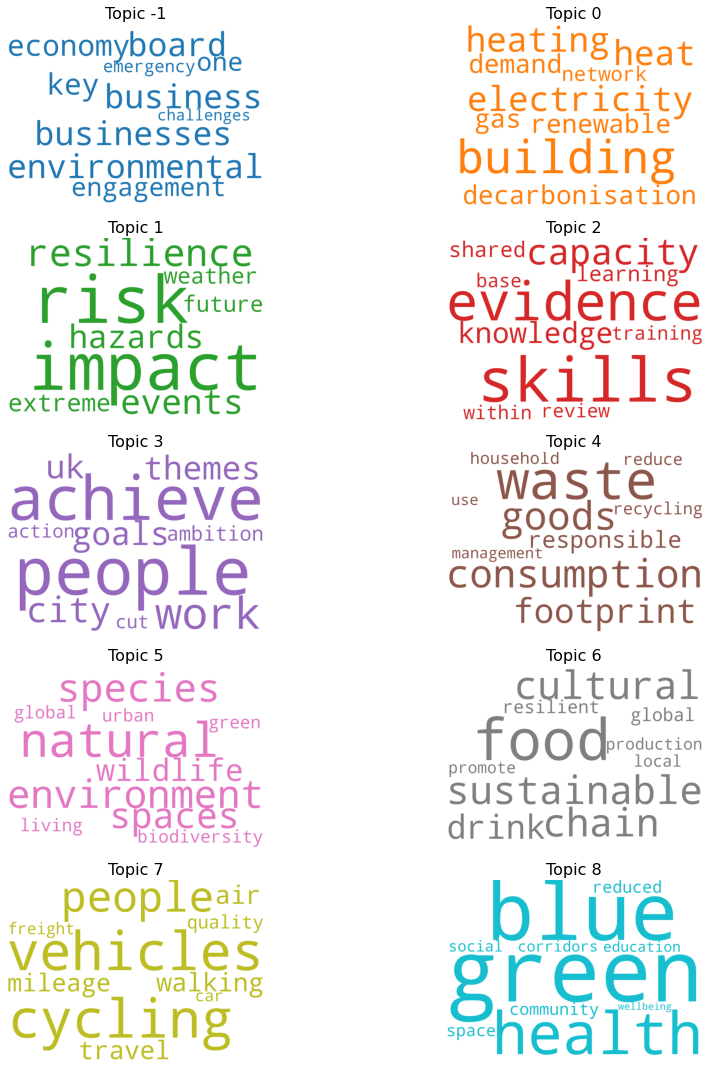

Resilience Strategy


In [ ]:
from bertopic import BERTopic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


def bert_preprocessing(docs):
    sp = WhiteSpacePreprocessing(doc_coref_resolved, stopwords_language='english')
    preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()
    return preprocessed_documents

def bert_topic(preprocessed_documents, min_topic_perc = 1/40, verbose = False):
    topic_model = BERTopic(min_topic_size=int(min_topic_perc * len(preprocessed_documents)), n_gram_range=(1,1), verbose = False)
    topics, _ = topic_model.fit_transform(preprocessed_documents)
    return(topic_model)

def wordcloud_topic(topic_model):
    # 1. Wordcloud of Top N words in each topic

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
    cols *= 10

    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab12',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    freq = topic_model.get_topic_info()
    topics = []
    for i in range( len(freq)):
        topic_i = topic_model.get_topic(i-1)
        topics.append([])
        for j in range(len(topic_i)):
            topics[i].append(topic_i[j][0])



    fig, axes = plt.subplots( int(len(freq)/2) + len(freq)%2,2, figsize=(15,15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i == len(freq):
            break
        fig.add_subplot(ax)
        cloud.generate(" ".join(topics[i]))
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i-1), fontdict=dict(size=16))
        plt.gca().axis('off')



    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

    
    
directory = "/Users/SB6282engie.com/Documents/Policy documents/Bristol/"
files = os.listdir(directory)
for file in files:
    print(file.split(".")[0])
    docs = extract_text(directory + file)
    docs = resolve_coref(docs)
    print("number of paragraphs : ",len(docs))
    preprocessed_documents = bert_preprocessing(docs)
    topic_model = bert_topic(preprocessed_documents)
    wordcloud_topic(topic_model)
    


In [332]:
docs

['',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '',
 'bristol.gov.uk',
 'something.',
 ' ',
 ' ',
 '',
 'bristol.',
 '',
 'bristol.',
 '',
 'bristol> ',
 'bristol> actions.',
 ' <<cut_here> bristol> it.',
 '',
 'bristol> perfect.',
 '',
 'bristol> ',
 'bristol> ',
 'situation.',
 '',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> does.',
 '',
 'bristol> ',
 'way.',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol.',
 'hope.',
 '',
 'bristol.',
 '',
 'bristol> ',
 'up.',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol.',
 '',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'play.',
 'bristol> plan.',
 '',
 'bristol> ',
 'bristol> ',
 'document.',
 'future.',
 '',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'bristol> ',
 'this.',
 'bristol> ',
 'changing. rates.',
 'year.',
 '.',
 'bristol> ',
 'bristol> ',
 'years.',
 '',
 'bristol> ',
 'bristol> '

# Bert CTM

In [16]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk

In [106]:

documents = docs
sp = WhiteSpacePreprocessing(documents, stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()
tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v1")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [228]:

ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=8, num_epochs=200, reduce_on_plateau = True)
ctm.fit(training_dataset, verbose = True) # run the model


Settings: 
                   N Components: 8
                   Topic Prior Mean: 0.0
                   Topic Prior Variance: 0.875
                   Model Type: prodLDA
                   Hidden Sizes: (100, 100)
                   Activation: softplus
                   Dropout: 0.2
                   Learn Priors: True
                   Learning Rate: 0.002
                   Momentum: 0.99
                   Reduce On Plateau: True
                   Save Dir: None


Epoch: [200/200]	 Seen Samples: [164800/164800]	Train Loss: 104.62433394645025	Time: 0:00:00.746687: : 200it [02:24,  1.38it/s]


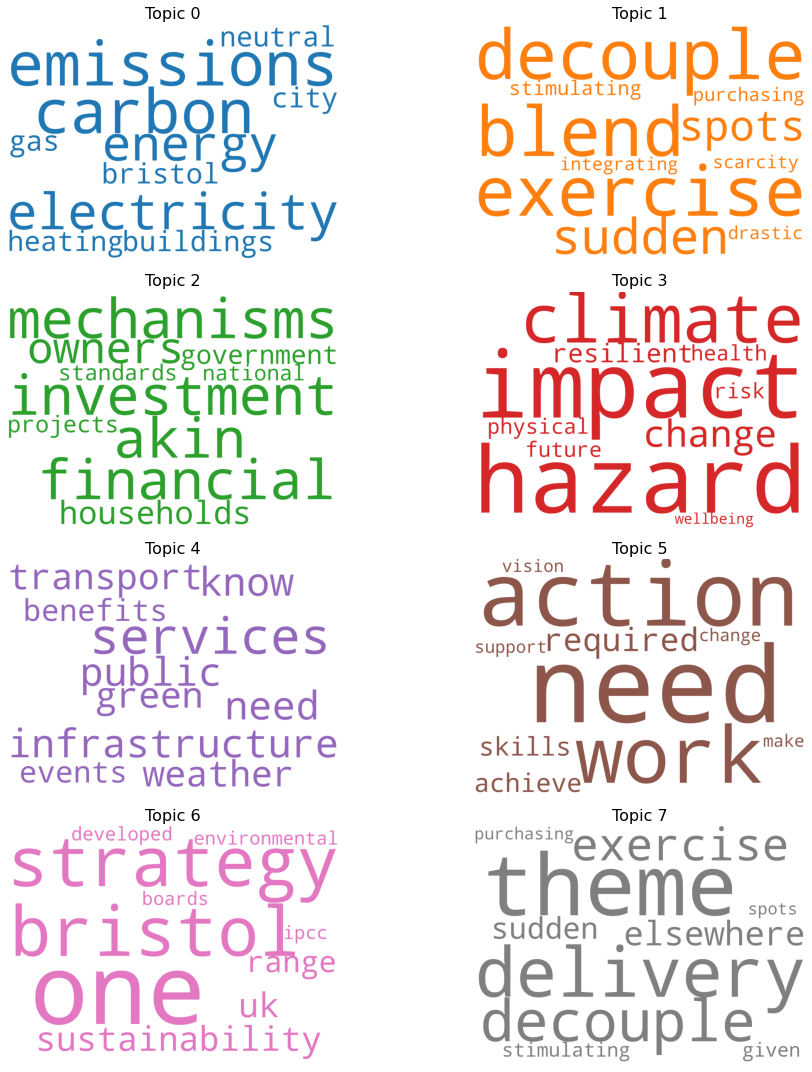

In [230]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cols *= 10

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab12',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ctm.get_topic_lists(20)

fig, axes = plt.subplots(4, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate(" ".join(topics[i]))
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [112]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:03,  3.32it/s]


In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cols *= 10

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab12',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ctm.get_topic_lists(10)

fig, axes = plt.subplots(20, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate(" ".join(topics[i]))
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

# LDA Model

In [82]:
#Tokenize by words
from gensim import corpora
from gensim.models import ldamodel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import wordnet
from gensim.models.coherencemodel import CoherenceModel
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(i)
        # add tokens to list
        texts.append(tokens)
    return texts
clean_docs= preprocess_data(doc_coref_resolved)



/Users/SB6282engie.com/opt/anaconda3/envs/py37NLP/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [83]:
#Compute bigrams, trigrams, quadgrams
import gensim
bigram = gensim.models.Phrases(clean_docs, min_count=5, threshold=90) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_docs], threshold=80)
quadgram = gensim.models.Phrases(trigram[clean_docs], threshold=70)
# Faster way to get a sentence clubbed as a trigram/bigram/quadgram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
quadgram_mod = gensim.models.phrases.Phraser(quadgram)


import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def make_quadgrams(texts):
    return [quadgram_mod[trigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(clean_docs)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_bigrams)
data_words_quadgrams = make_quadgrams(data_words_trigrams)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_quadgrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:10])

In [84]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dictionary,doc_term_matrix = prepare_corpus(data_lemmatized)

Start compute
0  /  29 last step took  3.0994415283203125e-06 s
1  /  29 last step took  0.4305438995361328 s
2  /  29 last step took  0.9889750480651855 s
3  /  29 last step took  1.0083868503570557 s
4  /  29 last step took  0.9709312915802002 s
5  /  29 last step took  1.16530179977417 s
6  /  29 last step took  1.0132927894592285 s
7  /  29 last step took  1.1257352828979492 s
8  /  29 last step took  1.1390719413757324 s
9  /  29 last step took  1.0470528602600098 s
10  /  29 last step took  1.0302541255950928 s
11  /  29 last step took  1.0451278686523438 s
12  /  29 last step took  1.07191801071167 s
13  /  29 last step took  1.085392951965332 s
14  /  29 last step took  2.2338531017303467 s
15  /  29 last step took  1.3028838634490967 s
16  /  29 last step took  1.2958431243896484 s
17  /  29 last step took  1.287424087524414 s
18  /  29 last step took  1.5245108604431152 s
19  /  29 last step took  1.3222920894622803 s
20  /  29 last step took  1.361548900604248 s
21  /  29 la

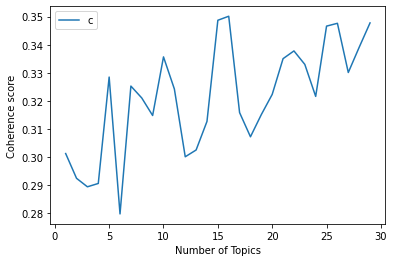

In [85]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    print("Start compute")
    model_list = []
    s1=time.time()
    for num_topics in range(start, stop, step):
        s=time.time()
        print(int((num_topics-start)/step), " / ", len(range(start, stop, step)),"last step took ", s-s1, "s")
        s1=s
        # generate LSA model
        model = ldamodel.LdaModel(corpus=doc_term_matrix,id2word=dictionary, num_topics = num_topics)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    print('highest coherence for : ', np.argmax(coherence_values)*step + start)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    return np.argmax(coherence_values)*step + start
start,stop,step=1,30,1
num_topics = plot_graph(data_lemmatized,start,stop,step)

In [93]:
def compute_coherence_values(doc_term_matrix, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [95]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 6
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))
beta.append('symmetric')
# Validation sets
num_of_docs = len(data_lemmatized)
corpus_sets = [gensim.utils.ClippedCorpus(data_lemmatized, num_of_docs*0.75), data_lemmatized]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=len(topics_range) * len(alpha) * len(beta))


    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(doc_term_matrix, dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

df = pd.read_csv('lda_tuning_results.csv')
df

bestdf = pd.DataFrame(columns = df.columns)
for i in range(2,max_topics):
    tmp = df[df["Topics"] == i].reset_index(drop= True)
    arg = tmp["Coherence"].argmax()
    bestdf = pd.concat([bestdf, tmp.loc[arg:arg,]]).reset_index(drop = True)
bestdf

plt.plot(range(2,max_topics), bestdf["Coherence"])
plt.xlabel("number of topics")
plt.ylabel("coherence")


  1%|          | 43/3696 [01:06<1:34:30,  1.55s/it]

 29%|██▉       | 155/528 [03:41<10:52,  1.75s/it]


 59%|█████▊    | 309/528 [07:51<06:06,  1.68s/it]


 88%|████████▊ | 463/528 [12:02<01:44,  1.60s/it]


100%|██████████| 528/528 [13:52<00:00,  1.58s/it]


ValueError: attempt to get argmax of an empty sequence

In [97]:
bestdf

,Topics,Alpha,Beta,Coherence
0,2,asymmetric,0.6100000000000001,0.415885
1,3,0.31000000000000005,0.11,0.408045
2,4,symmetric,0.21000000000000002,0.418326
3,5,0.01,0.11,0.419144


Text(0, 0.5, 'coherence')

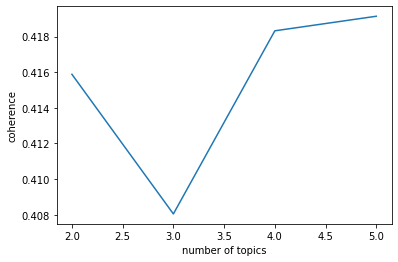

In [96]:

df = pd.read_csv('lda_tuning_results.csv')
df

bestdf = pd.DataFrame(columns = df.columns)
for i in range(2,max_topics):
    tmp = df[df["Topics"] == i].reset_index(drop= True)
    arg = tmp["Coherence"].argmax()
    bestdf = pd.concat([bestdf, tmp.loc[arg:arg,]]).reset_index(drop = True)
bestdf

plt.plot(range(2,max_topics), bestdf["Coherence"])
plt.xlabel("number of topics")
plt.ylabel("coherence")



In [98]:
lda = ldamodel.LdaModel(corpus=doc_term_matrix,id2word=dictionary, num_topics = 4, alpha= 'symmetric', eta=0.21)


In [99]:
from pprint import pprint
# Print the Keyword in the 12 topics
pprint(lda.print_topics())
doc_lda = lda[doc_term_matrix]



[(0,
  '0.011*"theme" + 0.007*"building" + 0.007*"people" + 0.006*"opportunity" + '
  '0.006*"impact" + 0.006*"waste" + 0.006*"include" + 0.006*"consumption" + '
  '0.006*"risk" + 0.005*"green"'),
 (1,
  '0.012*"business" + 0.010*"electricity" + 0.009*"food" + 0.009*"plan" + '
  '0.008*"local" + 0.008*"system" + 0.007*"require" + 0.007*"theme" + '
  '0.007*"action" + 0.007*"include"'),
 (2,
  '0.010*"opportunity" + 0.009*"impact" + 0.009*"action" + 0.009*"business" + '
  '0.008*"make" + 0.008*"new" + 0.008*"challenge" + 0.008*"organisation" + '
  '0.008*"reduce" + 0.007*"city"'),
 (3,
  '0.010*"work" + 0.009*"action" + 0.008*"business" + 0.007*"include" + '
  '0.006*"impact" + 0.006*"lead" + 0.006*"provide" + 0.006*"plan" + '
  '0.005*"resilience" + 0.005*"goal"')]


In [ ]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(doc_by_sent, show_progress_bar=True)


umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = [lda[doc_term_matrix[i]][0][0] for i in range(len(doc_term_matrix))]

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()



In [ ]:
def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=doc_term_matrix, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

In [ ]:
cols

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cols += cols[0:2]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab12',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(num_topics=12,formatted=False)

fig, axes = plt.subplots(6, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# LSA with lemmatization/sense2vec embedding

In [ ]:
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import wordnet
from gensim.models.coherencemodel import CoherenceModel
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    lemmatizer = wordnet.WordNetLemmatizer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(i)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop and not i.isdigit() and len(i)>2]
        # stem tokens
        stemmed_tokens = [lemmatizer.lemmatize(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
clean_docs= preprocess_data(docs)

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dic,matrix = prepare_corpus(clean_docs)

In [ ]:
import time
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    print("Start compute")
    model_list = []
    s1=time.time()
    for num_topics in range(start, stop, step):
        s=time.time()
        print(int((num_topics-start)/step), " / ", len(range(start, stop, step)),"last step took ", s-s1, "s")
        s1=s
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dic, matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    print('highest coherence for : ', np.argmax(coherence_values))
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
start,stop,step=1,30,1
plot_graph(clean_docs,start,stop,step)

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = words)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=7))
    return lsamodel
number_of_topics=16
lsamodel = create_gensim_lsa_model(clean_docs, number_of_topics, dic)

In [ ]:
SDG=["Poverty", "hunger", "health","education","gender equality","water","energy","economic","innovation infrastructure","equality", "sustainable","production","climate","life", "peace"]





In [ ]:
def extract_words_topics(lsamodel, number_of_topics):
    L=[]
    for i in range(number_of_topics):
        if len(L) == 0 or len(L[-1])>0:
            L.append([])
        topic=lsamodel.show_topic(i)
        for j in range(len(topic)):
            if topic[j][1]>0:
                L[-1].append(s2v.get_best_sense(topic[j][0]))
    return L
word_topics=extract_words_topics(lsamodel, number_of_topics)

In [ ]:
word_topics,lsamodel.show_topic(0)

In [ ]:
from sense2vec import Sense2Vec 
import numpy as np
s2v = Sense2Vec().from_disk("/Users/SB6282engie.com/Downloads/s2v_old")
similarity_matrix=np.zeros((len(SDG), len(word_topics)))
for i in range(len(SDG)):
    SDGlist = SDG[i].split(" ")
    for j in range(len(SDGlist)):
        SDGlist[j] = s2v.get_best_sense(SDGlist[j])
    for j in range(len(word_topics)):
        similarity_matrix[i,j] = s2v.similarity(SDGlist, word_topics[j])

In [ ]:
topics_names = [SDG[i] for i in np.argmax(similarity_matrix, axis=0)]
for i in range(len(topics_names)):
    print(i, topics_names[i], word_topics[i])

# HDBSCAN with UMAP and BERT Embedding

In [49]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(doc_coref_resolved, show_progress_bar=True)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [50]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=30, 
                            metric='cosine').fit_transform(embeddings)

In [63]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=40,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

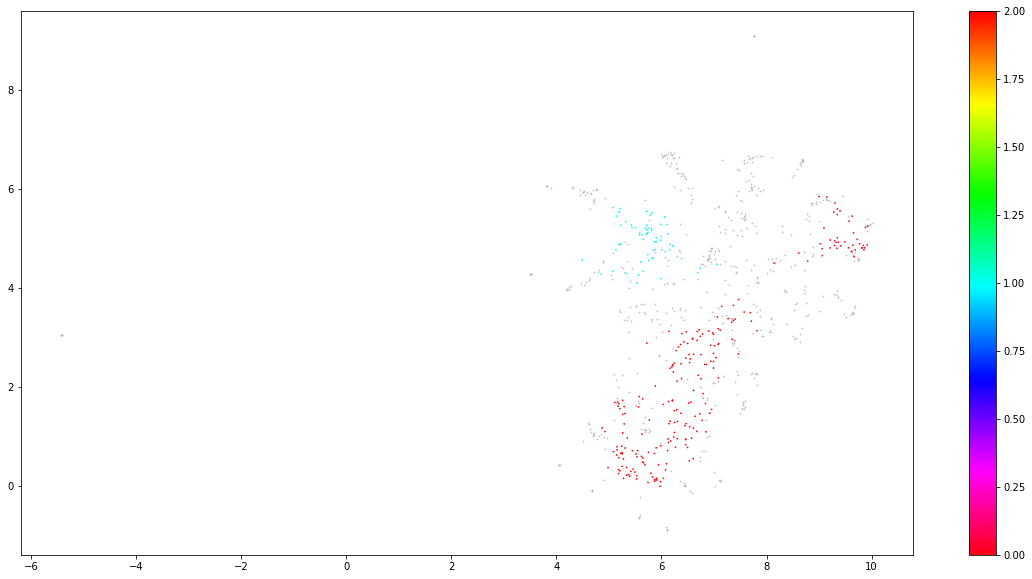

In [64]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [65]:
cluster.labels_

array([ 0, -1, -1,  0, -1,  2, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
        2,  0, -1, -1,  2, -1, -1, -1,  0, -1, -1, -1,  2, -1, -1, -1, -1,
       -1, -1,  2, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  2,  2, -1,
       -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2,
        2,  2,  2, -1,  2,  2, -1,  2,  2,  2,  2,  2, -1,  2, -1, -1, -1,
       -1, -1, -1, -1,  2,  1, -1, -1, -1, -1, -1, -1,  2, -1, -1,  2, -1,
        2,  2,  2, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        0, -1, -1,  0,  2, -1,  0,  1,  2, -1,  0, -1,  2, -1, -1, -1, -1,
        1,  2, -1, -1,  2,  0, -1,  2, -1,  0,  0, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1,  1, -1,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,
       -1,  1,  2, -1, -1, -1,  1, -1, -1, -1, -1, -1,  2,  2, -1, -1, -1,
        2, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1,
        2, -1,  0,  0,  2

In [68]:
clustered = {}
for i in np.unique(cluster.labels_):
    clustered[i] = np.where(cluster.labels_ == i)
    print(i, clustered[i])

-1 (array([  1,   2,   4,   6,   7,   8,  10,  11,  12,  13,  14,  15,  16,
        19,  20,  22,  23,  24,  26,  27,  28,  30,  31,  32,  33,  34,
        35,  37,  39,  40,  41,  43,  44,  45,  46,  47,  50,  51,  52,
        53,  55,  56,  57,  58,  59,  60,  61,  62,  71,  74,  80,  82,
        83,  84,  85,  86,  87,  88,  91,  92,  93,  94,  95,  96,  98,
        99, 101, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 120, 121, 124, 128, 130, 132, 133, 134, 135, 138, 139, 142,
       144, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 172, 174,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 190, 191, 192,
       194, 195, 196, 197, 198, 201, 202, 203, 205, 206, 207, 208, 209,
       210, 211, 212, 215, 216, 217, 218, 219, 220, 222, 226, 227, 228,
       229, 231, 232, 233, 234, 236, 238, 239, 241, 242, 245, 246, 248,
       251, 252, 253, 255, 259, 260, 262, 265, 268, 269, 270

In [69]:
for key in clustered:
    
    print(key)
    for page in clustered[key][0]:
        print("Still on ", key)
        print(page)
        print(doc_coref_resolved[page])
    print("_________________________")

-1
Still on  -1
1
foreword one environmental sustainability board
Still on  -1
2
facing emergency. act now reduce direct indirect net zero. prepare adapt deal projected impacts change.
Still on  -1
4
achieve over next decade radically rethink how live work invest city.
Still on  -1
6
provides opportunity take collaborative inclusive citywide approach make fair transition.
Still on  -1
7
environmental sustainability board proud lead transition city. representing range organisations come together set out shared vision strategy.
Still on  -1
8
given strong history delivering action excited work hand hand across continue lead way. move faster than national average learning other cities journey.
Still on  -1
10
recognise achieving vision not easy. there entrenched market wider forces existing fossil fuel dependent consumption based systems. show strong leadership create opportunities participate benefits strong leadership costs shared fairly.
Still on  -1
11
exciting opportunity address cha

502
employment accelerated network upgrade pv installations smart implementation
Still on  -1
504
community investment local trading potentially benefit more vulnerable households pv installations.
Still on  -1
505
challenge cities drive wider global economy consumption has impact well beyond boundaries can reduce amount consume city. just under 50 footprint households comes indirect scope 3 sources approximately 50 these emanating outside uk.
Still on  -1
506
management waste currently causes c. 5 scope 1 2 largely result incineration residual waste particularly fossil fuel derived plastics > management waste contains.
Still on  -1
507
know extreme weather events caused hazards other parts world put some goods currently rely at risk. addition food see theme 9 committee has highlighted clothes electronic equipment especially at risk risk risk international supply chains.
Still on  -1
511
theme 5 consumption waste
Still on  -1
512
theme 5 consumption waste
Still on  -1
514
retail econom

next steps 2020 parallel planning develop clear framework monitoring review subsequent years.
Still on  0
769
given prioritise direct interventions reduce offsetting considered get closer 2030.
Still on  0
770
however given potential lead times assemble finance across partners potential land assembly other complexities resolve proposing review offsetting requirements late 2020s.
Still on  0
798
resilient 2030 used term mean being prepared through adaptive planning global temperature rise up 4.3oc 2100 compared pre industrial levels.
Still on  0
809
arup 2020a resilience assessment
Still on  0
811
council bcc 2018 leap prospectus energyservicebristol.co.uk wp content pdf leap prospectus 204 5 18.pdf
Still on  0
815
ceuk 2018 emergency uk 14 november 2018 online at blog council declares emergency
Still on  0
828
qol 2019 council quality life survey 2019 20
_________________________
1
Still on  1
38
1. transport switching significantly more walking cycling zero transport modes converting 

In [ ]:
clustered[-1]

# Bert Topic

In [304]:
topic_model.visualize_topics()

In [310]:
processed = topic_model.get_representative_docs(2)
for i,doc in enumerate(processed):
    index = preprocessed_documents.index(doc)
    print(i, docs[index], index)

0 production predominantly generation manufacturing distribution provision account 82 business economy footprint. service based sectors finance real estate consultancy account much smaller proportions business emissions. 136
1 changes likely make extreme events likely. international events impact local economy business international chains many companies do not review monitor resilience their chains. 552
2 leads responsible consumption take develop business models focus sustainable consumption reducing waste developing circular economy. longer term goal one plan us become zero waste city. 511


In [239]:
docs[722]

'extent criticality'

In [309]:
topic_model.find_topics("energy")

([0, 7, 8, 4, 3],
 [0.7286398775321473,
  0.541599895967473,
  0.5081572577809224,
  0.500763354451335,
  0.5003896423377276])

# Computing similarity

In [140]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt


# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [145]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [151]:
model = BertTokenizer.from_pretrained('bert-base-uncased')
embeddings = model.encode(["heat is though"], show_progress_bar=True)



In [152]:
embeddings

[101, 100, 102]